In [2]:
import os as os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import sklearn as sklearn
from pandas.plotting import scatter_matrix

import seaborn as sns
%matplotlib inline

os.listdir("../../data")#raw data
os.listdir("../../filled_in_data/")#cleaned data
location = 'B'
raw_data_path=(f"../../data/{location}/")
cleaned_data_path = (f'../../filled_in_data/{location}/')

path = raw_data_path#raw_data_path#
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

#### Task from presentation


The problem #1:
We do not know future weather
But we can use weather predictions!
Every day a meteorologist sends us his weather predictions for 
the next day (24 h) for all 45 features. 
Your system is supposed to take these predictions as Xtest and use
it to predict solar energy production Ytest

The problem #2:
Weather predictions differ from real 
observed weather
If you train your model on real weather
but predict future using estimated weather
there will be a risk of an error. 
Your model must adapt to the distribution difference between real 
weather and estimated weather.

## 00 Loading and merging dataframes

In [3]:
#Convert from parquet to pandas dataframes
#Training data - actual weather
X_train_observed = pd.read_parquet(path + 'X_train_observed.parquet') #X_train_observed_a.shape -> (118669, 46)
#Training data - estimated weather
X_train_estimated = pd.read_parquet(path + 'X_train_estimated.parquet') #X_train_estimated_a.shape -> (17576, 47)
#Training values (PV)
train_targets = pd.read_parquet(path + 'train_targets.parquet') #train_a.shape -> (34085, 2)
#Testing values - estimated weather
X_test_estimated = pd.read_parquet(path + 'X_test_estimated.parquet') #X_test_estimated_a.shape -> (2880, 47)

#Test values - selected rows
#df_test_submission_rows = pd.read_csv(path + 'test.csv')

all_dataframes = {
    'X_train_observed': X_train_observed,
    'X_train_estimated' : X_train_estimated,
    'train_targets' : train_targets,
#    'df_test_submission_rows' : df_test_submission_rows   
}


In [4]:
X_train_observed.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-01-01 00:00:00                       5.6                1.239   
1 2019-01-01 00:15:00                       5.6                1.239   
2 2019-01-01 00:30:00                       5.5                1.240   
3 2019-01-01 00:45:00                       5.4                1.241   
4 2019-01-01 01:00:00                       5.4                1.241   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1226.400024                    0.0              0.0   
1           1209.300049                    0.0              0.0   
2           1192.099976                    0.0              0.0   
3           1174.900024                    0.0              0.0   
4           1157.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  \
0       1226.400024              0.0      275.399994            0.0   
1       1209.300049              0.0      275.200012            0.0   
2       1192.099976              0.0      275.100006            0.0   
3       1174.900024              0.0      274.899994            0.0   
4       1157.599976              0.0      274.700012            0.0   

   diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
0               0.0           0.0              0.0                69.599998   
1               0.0           0.0              0.0                78.599998   
2               0.0           0.0              0.0                86.300003   
3               0.0           0.0              0.0                92.800003   
4               0.0           0.0              0.0                98.099998   

   elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  fresh_snow_24h:cm  \
0          7.0                0.0               0.0                0.0   
1          7.0                0.0               0.0                0.0   
2          7.0                0.0               0.0                0.0   
3          7.0                0.0               0.0                0.0   
4          7.0                0.0               0.0                0.0   

   fresh_snow_3h:cm  fresh_snow_6h:cm  is_day:idx  is_in_shadow:idx  \
0               0.0               0.0         0.0               1.0   
1               0.0               0.0         0.0               1.0   
2               0.0               0.0         0.0               1.0   
3               0.0               0.0         0.0               1.0   
4               0.0               0.0         0.0               1.0   

   msl_pressure:hPa  precip_5min:mm  precip_type_5min:idx  pressure_100m:hPa  \
0        987.400024            0.00                   0.0         974.500000   
1        987.099976            0.05                   1.0         974.200012   
2        986.900024            0.05                   1.0         974.000000   
3        986.599976            0.05                   1.0         973.700012   
4        986.299988            0.05                   1.0         973.400024   

   pressure_50m:hPa  prob_rime:p  rain_water:kgm2  \
0        980.599976          0.0              0.0   
1        980.299988          0.0              0.0   
2        980.000000          0.0              0.0   
3        979.799988          0.0              0.0   
4        979.500000          0.0              0.0   

   relative_humidity_1000hPa:p  sfc_pressure:hPa  snow_density:kgm3  \
0                    89.199997        986.599976                NaN   
1                    89.099998        986.400024                NaN   
2                    89.099998        986.099976                NaN   
3                    89.000000        985.799988                NaN   
4                    88.900002        985.599976                NaN   

   snow_depth:cm  snow_drift:idx  snow_melt_10min:mm  snow_water:kgm2  \
0            0.0             0.0                -0.0              0.0   
1            0.0         

### Merging all train (observed and estimated), not targets -> 136 245 rows

In [5]:
df_just_train_no_targets = pd.concat([X_train_observed, X_train_estimated], ignore_index=True)
df_just_train_no_targets.shape 

(151286, 47)

### Merging train and targets

In [6]:
to_concat = []
for column in [X_train_observed, X_train_estimated]:
    df_to_add = pd.merge(left = train_targets, right = column, left_on="time", right_on="date_forecast") #df_to_add is just one frame
    to_concat.append(df_to_add)

df_train_and_targets = pd.concat(to_concat, ignore_index=True)

In [7]:
df_train_and_targets.head()

time  pv_measurement       date_forecast  \
0 2019-01-01 00:00:00             0.0 2019-01-01 00:00:00   
1 2019-01-01 00:15:00             0.0 2019-01-01 00:15:00   
2 2019-01-01 00:30:00             0.0 2019-01-01 00:30:00   
3 2019-01-01 00:45:00             0.0 2019-01-01 00:45:00   
4 2019-01-01 01:00:00             0.0 2019-01-01 01:00:00   

   absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
0                       5.6                1.239           1226.400024   
1                       5.6                1.239           1209.300049   
2                       5.5                1.240           1192.099976   
3                       5.4                1.241           1174.900024   
4                       5.4                1.241           1157.599976   

   clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
0                    0.0              0.0       1226.400024              0.0   
1                    0.0              0.0       1209.300049              0.0   
2                    0.0              0.0       1192.099976              0.0   
3                    0.0              0.0       1174.900024              0.0   
4                    0.0              0.0       1157.599976              0.0   

   dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  \
0      275.399994            0.0               0.0           0.0   
1      275.200012            0.0               0.0           0.0   
2      275.100006            0.0               0.0           0.0   
3      274.899994            0.0               0.0           0.0   
4      274.700012            0.0               0.0           0.0   

   direct_rad_1h:J  effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
0              0.0                69.599998          7.0                0.0   
1              0.0                78.599998          7.0                0.0   
2              0.0                86.300003          7.0                0.0   
3              0.0                92.800003          7.0                0.0   
4              0.0                98.099998          7.0                0.0   

   fresh_snow_1h:cm  fresh_snow_24h:cm  fresh_snow_3h:cm  fresh_snow_6h:cm  \
0               0.0                0.0               0.0               0.0   
1               0.0                0.0               0.0               0.0   
2               0.0                0.0               0.0               0.0   
3               0.0                0.0               0.0               0.0   
4               0.0                0.0               0.0               0.0   

   is_day:idx  is_in_shadow:idx  msl_pressure:hPa  precip_5min:mm  \
0         0.0               1.0        987.400024            0.00   
1         0.0               1.0        987.099976            0.05   
2         0.0               1.0        986.900024            0.05   
3         0.0               1.0        986.599976            0.05   
4         0.0               1.0        986.299988            0.05   

   precip_type_5min:idx  pressure_100m:hPa  pressure_50m:hPa  prob_rime:p  \
0                   0.0         974.500000        980.599976          0.0   
1                   1.0         974.200012        980.299988          0.0   
2                   1.0         974.000000        980.000000          0.0   
3                   1.0         973.700012        979.799988          0.0   
4                   1.0         973.400024        979.500000          0.0   

   rain_water:kgm2  relative_humidity_1000hPa:p  sfc_pressure:hPa  \
0              0.0                    89.199997        986.599976   
1              0.0                    89.099998        986.400024   
2              0.0                    89.099998        986.099976   
3              0.0                    89.000000        985.799988   
4              0.0                    88.900002        985.599976   

   snow_density:kgm3  snow_depth:cm  snow_drift:idx  snow_melt_10min:mm  \
0  

## 01 Distribution of data

#### Histogram of all features

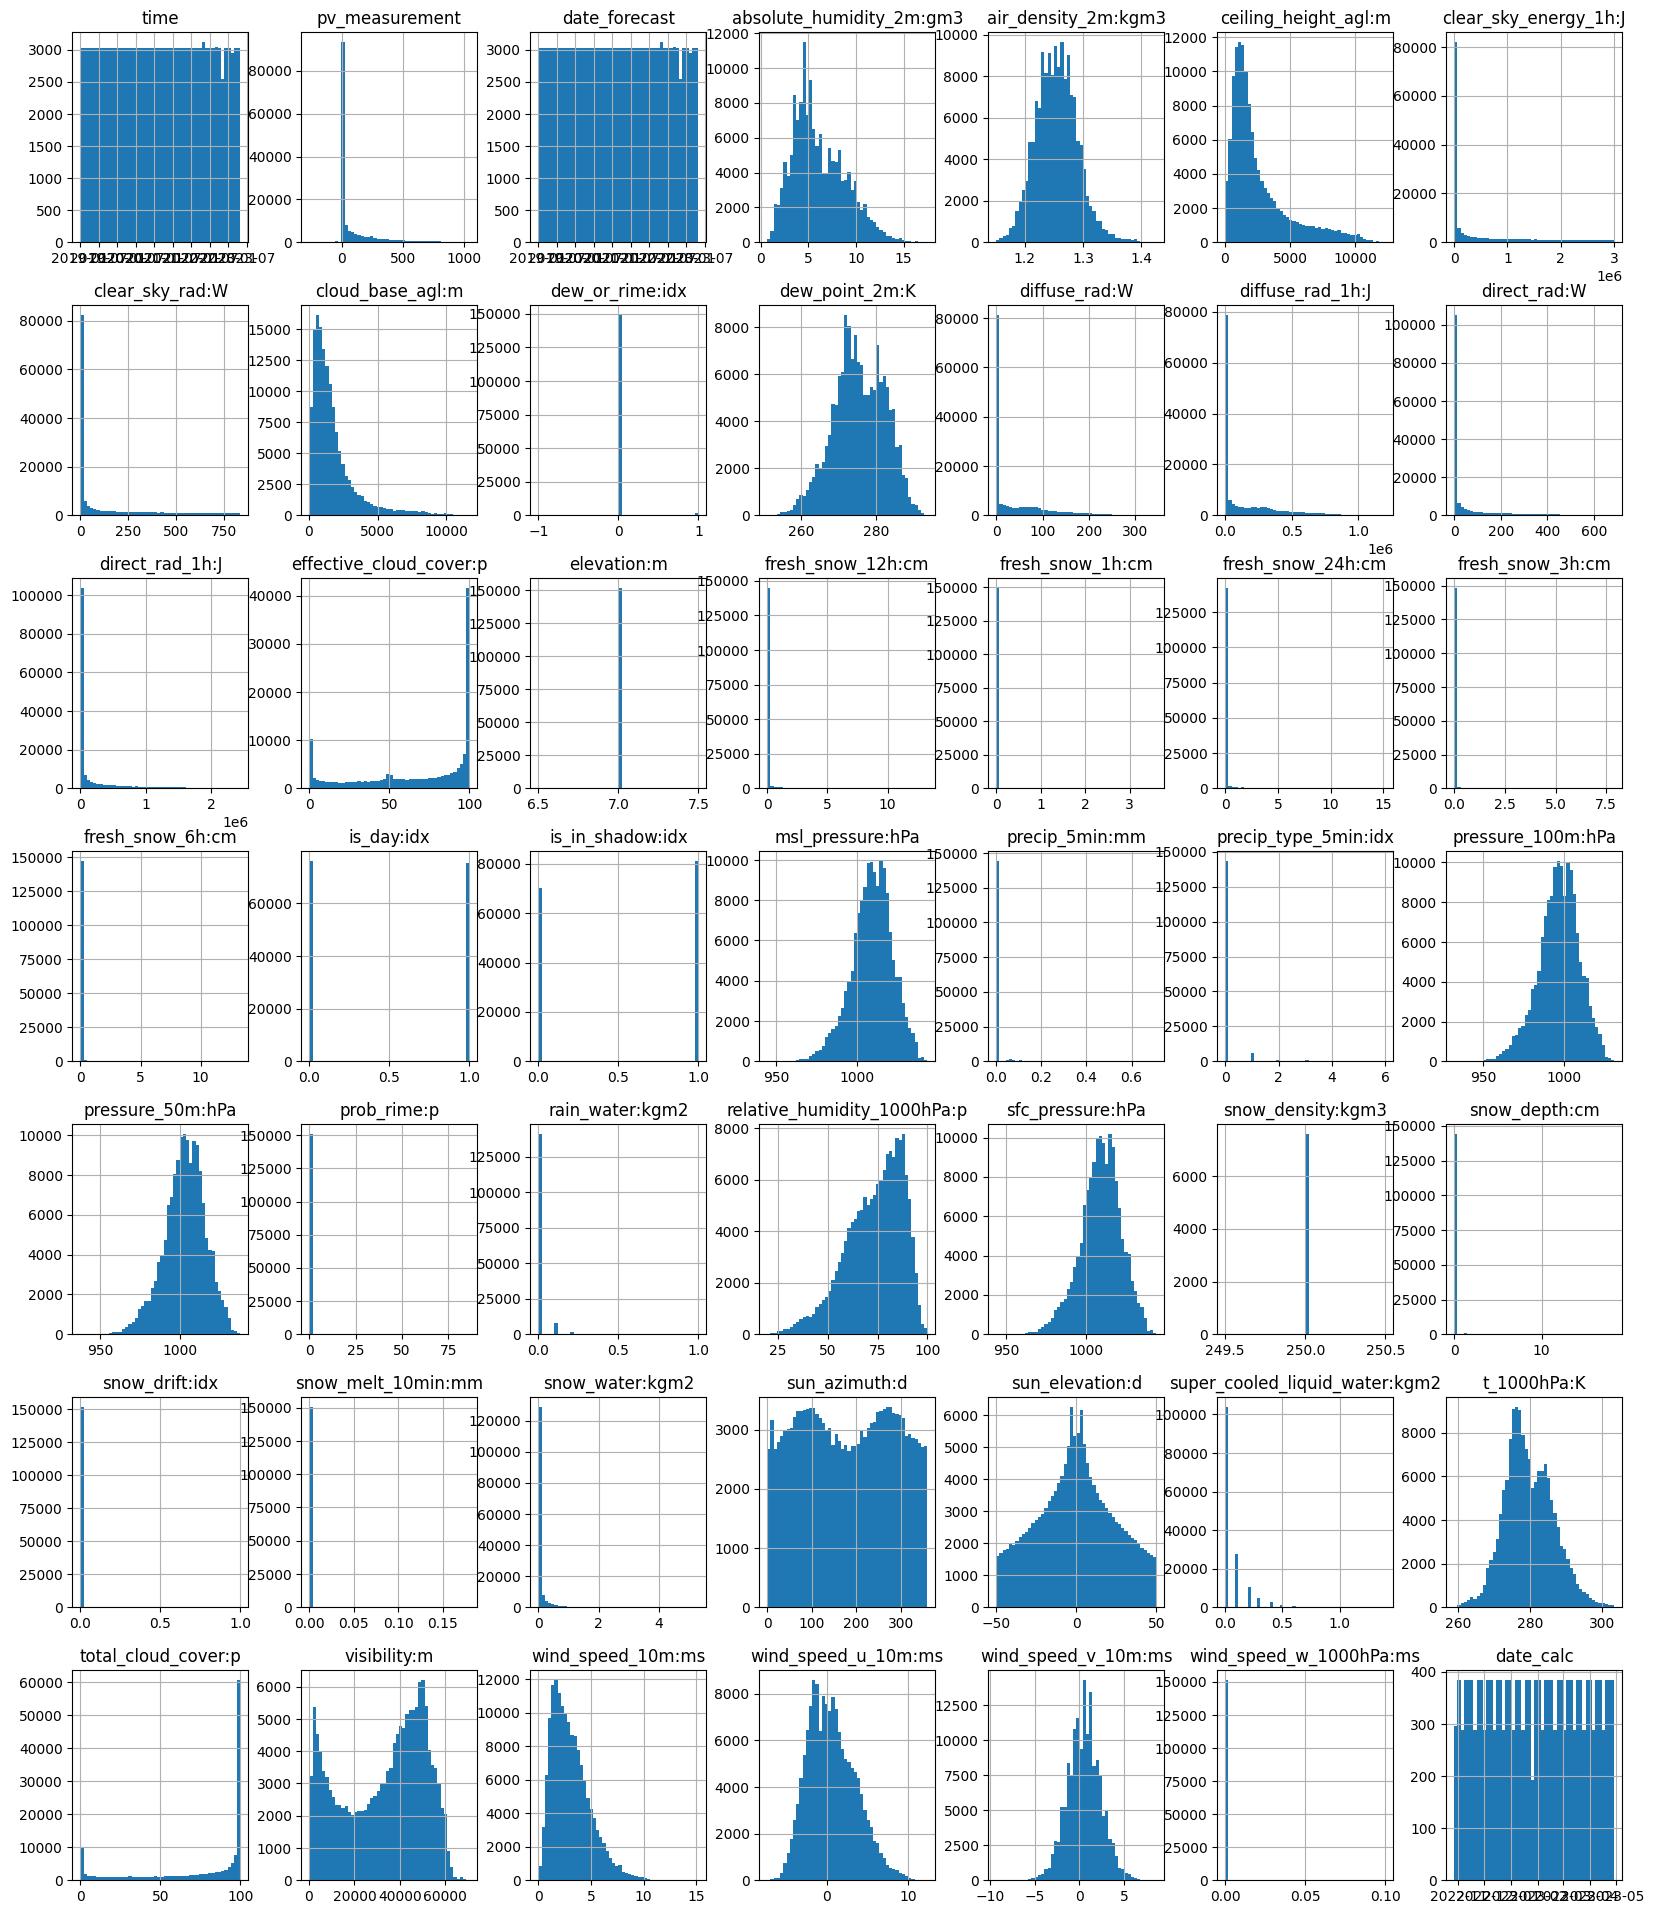

In [8]:
df_train_and_targets.hist(bins=50, figsize=(20,24))
plt.show();

In [9]:
# import math
# df_train_and_targets['pv_measurement'] = df_train_and_targets['pv_measurement'].apply(lambda x: math.sqrt(x))
# df_train_and_targets['wind_speed_10m:ms'] = df_train_and_targets['wind_speed_10m:ms'].apply(lambda x: math.sqrt(x))
# df_train_and_targets['ceiling_height_agl:m'] = df_train_and_targets['ceiling_height_agl:m'].apply(lambda x: math.sqrt(x))

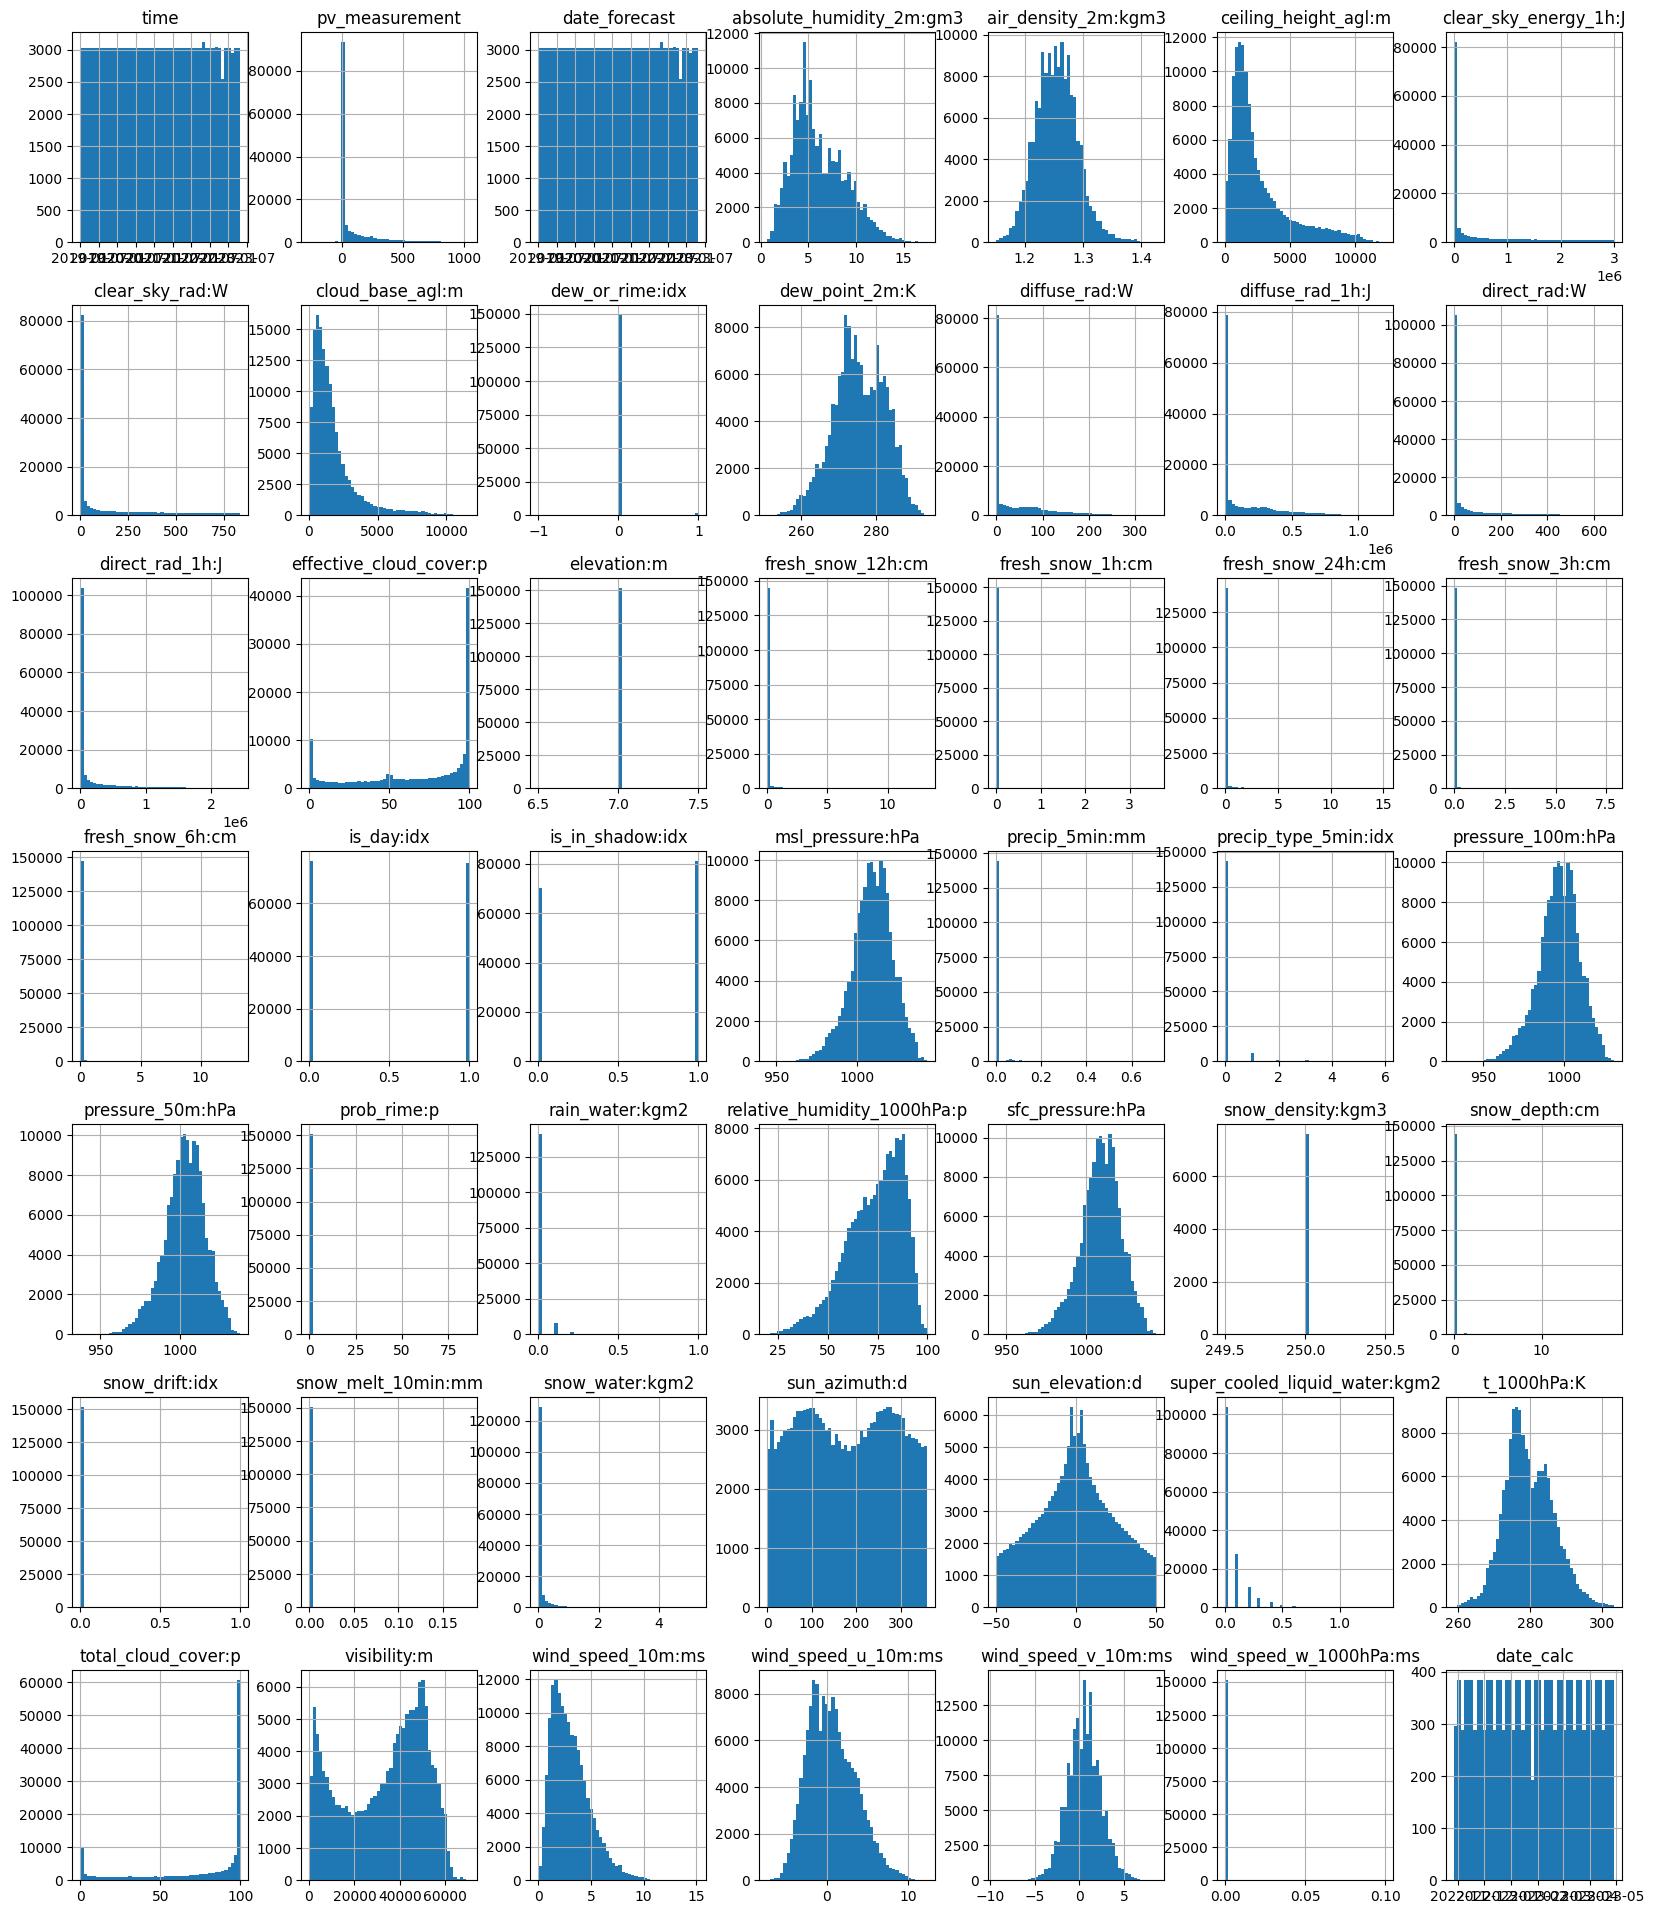

In [10]:
df_train_and_targets.hist(bins=50, figsize=(20,24))
plt.show();

#### All features plotted against time

<Axes: title={'center': 'Train/Test  A'}, xlabel='date_forecast'>

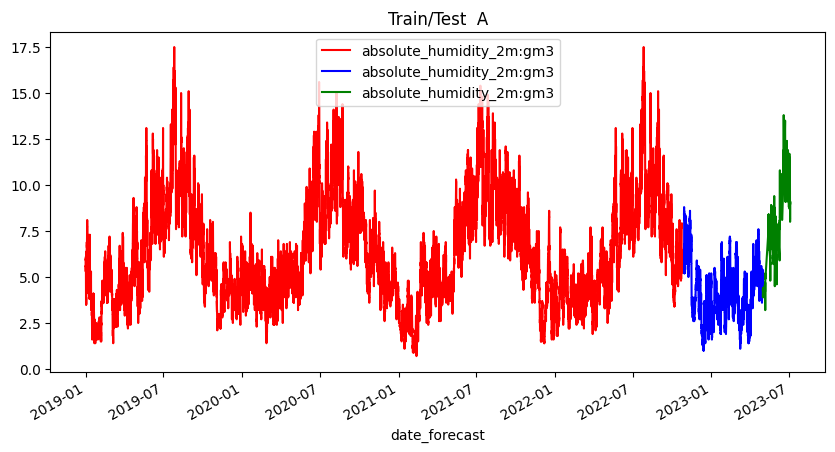

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
feature_name = 'absolute_humidity_2m:gm3'
X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=ax, title='Train/Test A', color='red')
X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=ax, title='Train/Test A', color='blue')
X_test_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=ax, title='Train/Test  A', color='green')


In [12]:
# import matplotlib.pyplot as plt

# features = list(df_train_and_targets.columns)  # list of your features

# # Calculate the number of rows and columns needed
# n_rows = len(features) // 3
# n_cols = 3

# # If features cannot be evenly distributed across rows, add an additional row
# if len(features) % 3 != 0:
#     n_rows += 1

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# # Flatten axs for easy iteration
# axs = axs.ravel()

# for i, feature in enumerate(features):
#     df_train_and_targets.plot(y=feature, ax=axs[i], title=feature)
#     axs[i].set_ylabel('')

# # Hide any unused subplots
# for i in range(len(features), n_rows * n_cols):
#     axs[i].axis('off')

# plt.tight_layout()
# #plt.show();


## 02 Missing values

In [13]:
df_train_and_targets.isna().sum().sort_values(ascending = False)

snow_density:kgm3                 143686
date_calc                         133701
ceiling_height_agl:m               23328
cloud_base_agl:m                   10303
snow_water:kgm2                        0
pressure_50m:hPa                       0
prob_rime:p                            0
rain_water:kgm2                        0
relative_humidity_1000hPa:p            0
sfc_pressure:hPa                       0
snow_depth:cm                          0
snow_drift:idx                         0
snow_melt_10min:mm                     0
sun_elevation:d                        0
sun_azimuth:d                          0
precip_type_5min:idx                   0
super_cooled_liquid_water:kgm2         0
t_1000hPa:K                            0
total_cloud_cover:p                    0
visibility:m                           0
wind_speed_10m:ms                      0
wind_speed_u_10m:ms                    0
wind_speed_v_10m:ms                    0
wind_speed_w_1000hPa:ms                0
pressure_100m:hP

### Missing rows

In [14]:
# Convert 'date_forecast' to datetime
df_just_train_no_targets['date_forecast'] = pd.to_datetime(df_just_train_no_targets['date_forecast'])
#Sort dataframe by 'date_forecast'
df_just_train_no_targets = df_just_train_no_targets.sort_values(by='date_forecast')
# # Compute the difference between consecutive dates
df_just_train_no_targets['date_diff'] = df_just_train_no_targets['date_forecast'].diff()
# # Identify rows where the difference is greater than 1 day
gaps = df_just_train_no_targets[df_just_train_no_targets['date_diff'] > pd.Timedelta(days=1)]

# # Print gaps in a clean format
for index, row in gaps.iterrows():
    start_gap = row['date_forecast'] - row['date_diff']
    end_gap = row['date_forecast'] - pd.Timedelta(days=1)
    print(f"Gap from {start_gap.date()} to {end_gap.date()} ({row['date_diff'].days - 1} days)")


Gap from 2022-10-23 to 2022-10-27 (4 days)
Gap from 2023-01-25 to 2023-01-26 (0 days)


### Identifying missing gaps

In [15]:
#df_just_train_no_targets.info()

In [16]:
train_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151308 entries, 0 to 151307
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   time            151308 non-null  datetime64[us]
 1   pv_measurement  151308 non-null  float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 2.3 MB


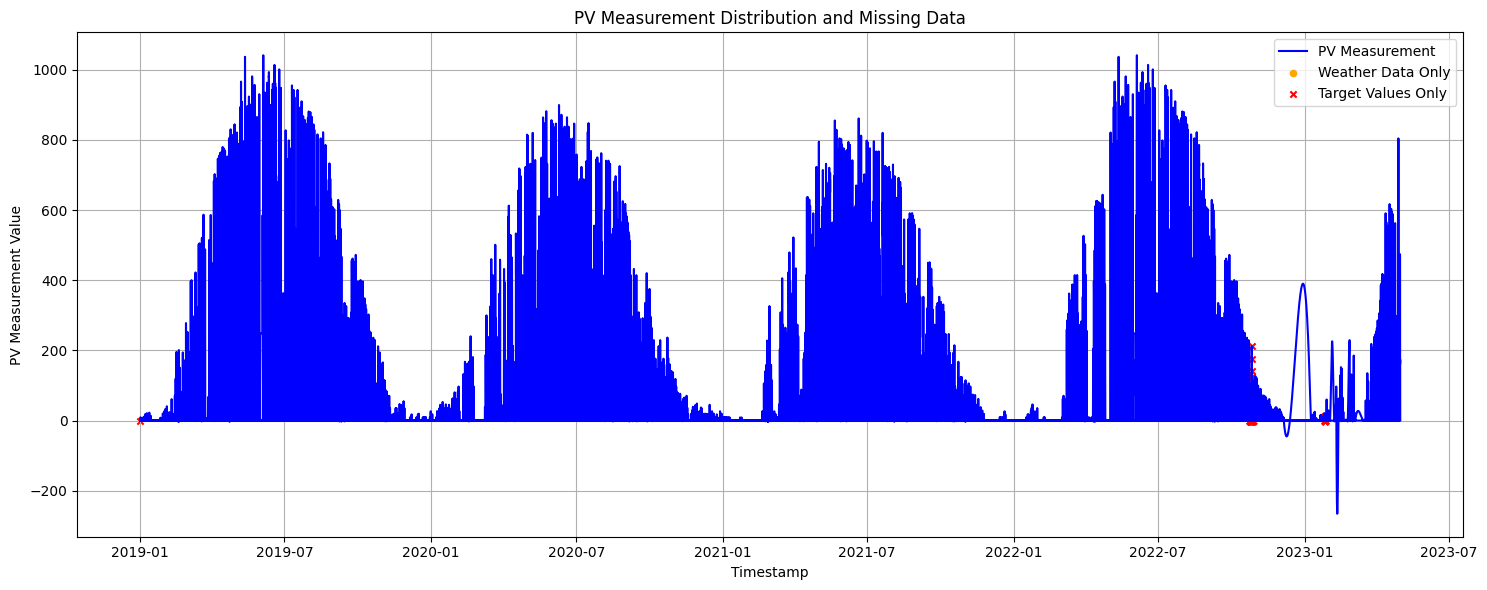

In [17]:
# Merge dataframes on timestamp
merged_df = pd.merge(df_just_train_no_targets, train_targets, left_on='date_forecast', right_on='time', how='outer')

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot pv_measurement values using a line plot
plt.plot(merged_df['time'], merged_df['pv_measurement'], label='PV Measurement', color='blue')

# Highlight timestamps with only weather data using scatter plot
weather_only_mask = merged_df['pv_measurement'].isna()
plt.scatter(merged_df[weather_only_mask]['time'], [0] * weather_only_mask.sum(), color='orange', marker='o', s=20, label='Weather Data Only')

# Highlight timestamps with only target values using scatter plot
target_only_mask = merged_df['date_forecast'].isna()
plt.scatter(merged_df[target_only_mask]['time'], merged_df[target_only_mask]['pv_measurement'], color='red', marker='x', s=20, label='Target Values Only')

# Customizations
plt.xlabel('Timestamp')
plt.ylabel('PV Measurement Value')
plt.title('PV Measurement Distribution and Missing Data')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



In [18]:
df_merged_inner = pd.merge(df_just_train_no_targets, train_targets, left_on='date_forecast', right_on='time', how='inner')
df_merged_outer = pd.merge(df_just_train_no_targets, train_targets, left_on='date_forecast', right_on='time', how='outer')
print(df_merged_inner.shape)
print(df_merged_outer.shape)
df_merged_outer.head()

(151277, 50)
(151412, 50)


date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-01-01 00:00:00                       5.6                1.239   
1 2019-01-01 00:15:00                       5.6                1.239   
2 2019-01-01 00:30:00                       5.5                1.240   
3 2019-01-01 00:45:00                       5.4                1.241   
4 2019-01-01 01:00:00                       5.4                1.241   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1226.400024                    0.0              0.0   
1           1209.300049                    0.0              0.0   
2           1192.099976                    0.0              0.0   
3           1174.900024                    0.0              0.0   
4           1157.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  \
0       1226.400024              0.0      275.399994            0.0   
1       1209.300049              0.0      275.200012            0.0   
2       1192.099976              0.0      275.100006            0.0   
3       1174.900024              0.0      274.899994            0.0   
4       1157.599976              0.0      274.700012            0.0   

   diffuse_rad_1h:J  direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
0               0.0           0.0              0.0                69.599998   
1               0.0           0.0              0.0                78.599998   
2               0.0           0.0              0.0                86.300003   
3               0.0           0.0              0.0                92.800003   
4               0.0           0.0              0.0                98.099998   

   elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  fresh_snow_24h:cm  \
0          7.0                0.0               0.0                0.0   
1          7.0                0.0               0.0                0.0   
2          7.0                0.0               0.0                0.0   
3          7.0                0.0               0.0                0.0   
4          7.0                0.0               0.0                0.0   

   fresh_snow_3h:cm  fresh_snow_6h:cm  is_day:idx  is_in_shadow:idx  \
0               0.0               0.0         0.0               1.0   
1               0.0               0.0         0.0               1.0   
2               0.0               0.0         0.0               1.0   
3               0.0               0.0         0.0               1.0   
4               0.0               0.0         0.0               1.0   

   msl_pressure:hPa  precip_5min:mm  precip_type_5min:idx  pressure_100m:hPa  \
0        987.400024            0.00                   0.0         974.500000   
1        987.099976            0.05                   1.0         974.200012   
2        986.900024            0.05                   1.0         974.000000   
3        986.599976            0.05                   1.0         973.700012   
4        986.299988            0.05                   1.0         973.400024   

   pressure_50m:hPa  prob_rime:p  rain_water:kgm2  \
0        980.599976          0.0              0.0   
1        980.299988          0.0              0.0   
2        980.000000          0.0              0.0   
3        979.799988          0.0              0.0   
4        979.500000          0.0              0.0   

   relative_humidity_1000hPa:p  sfc_pressure:hPa  snow_density:kgm3  \
0                    89.199997        986.599976                NaN   
1                    89.099998        986.400024                NaN   
2                    89.099998        986.099976                NaN   
3                    89.000000        985.799988                NaN   
4                    88.900002        985.599976                NaN   

   snow_depth:cm  snow_drift:idx  snow_melt_10min:mm  snow_water:kgm2  \
0            0.0             0.0                -0.0              0.0   
1            0.0         

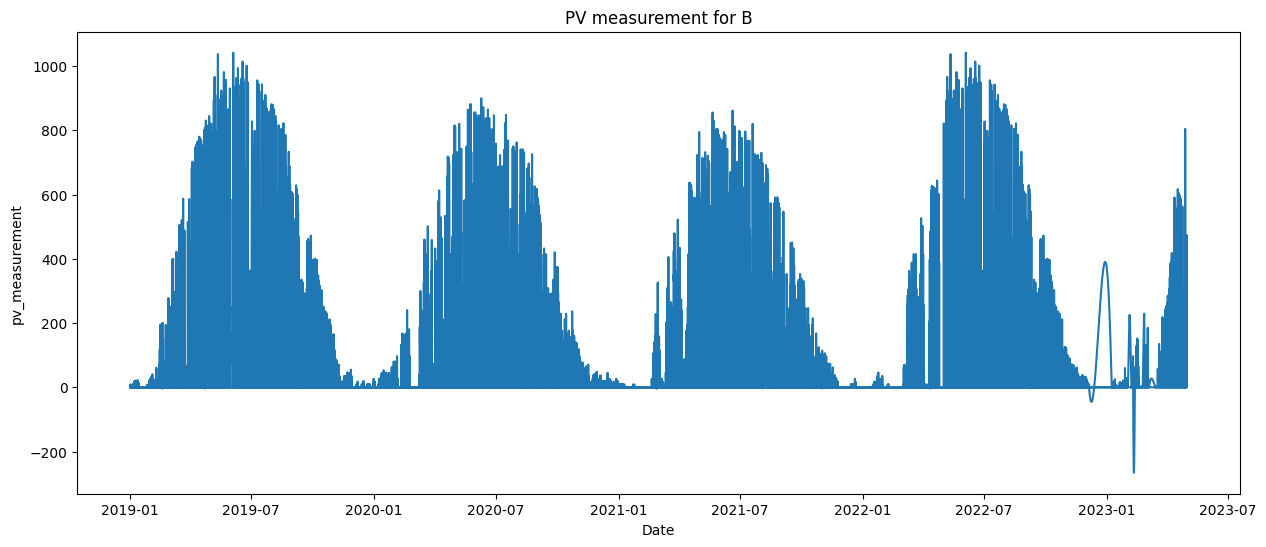

In [19]:

#all_dataframes['train_targets'].sort_values(by = 'time')
plt.figure( figsize= (15, 6))
plt.plot(all_dataframes['train_targets']['time'], all_dataframes['train_targets']['pv_measurement'])
plt.xlabel('Date')
plt.ylabel('pv_measurement')
plt.title(f'PV measurement for {location}')
plt.show()

##### plotting without fill between

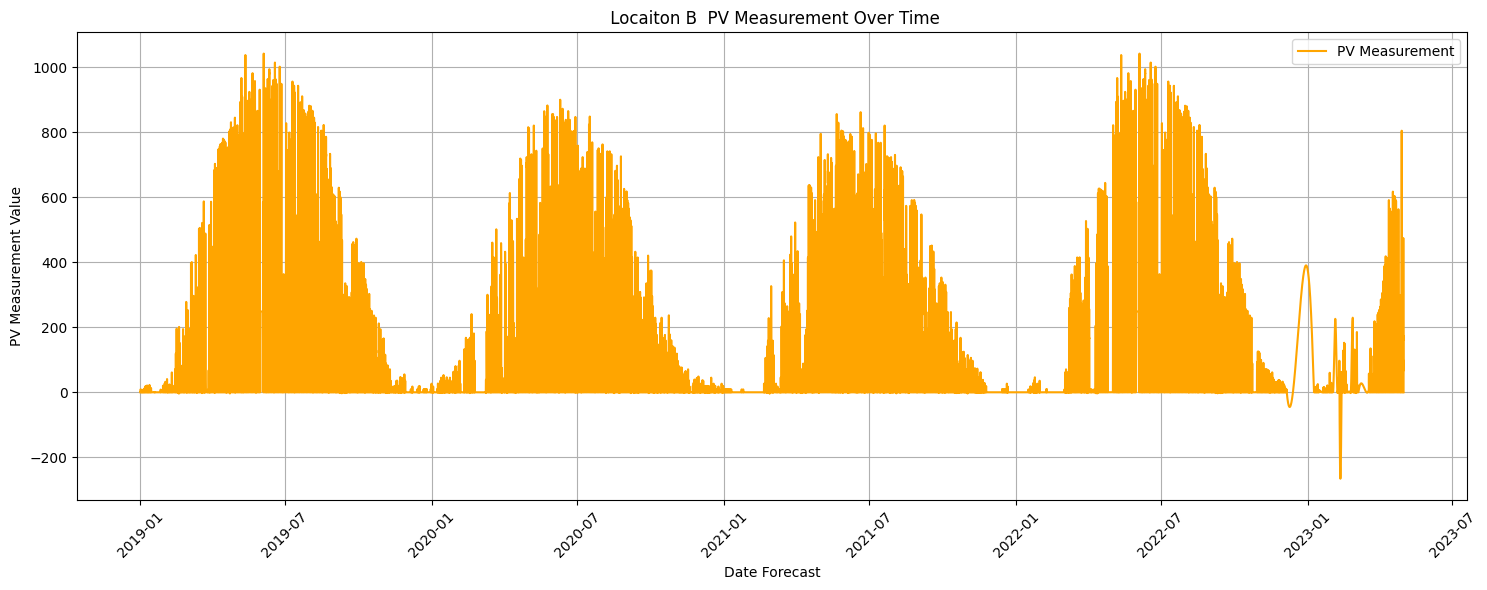

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(df_merged_inner['date_forecast'], df_merged_inner['pv_measurement'], label='PV Measurement', color='orange')
plt.title(f' Locaiton {location}  PV Measurement Over Time')
plt.xlabel('Date Forecast')
plt.ylabel('PV Measurement Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Missing features

In [21]:
for dataframe, dataseries in all_dataframes.items():
    print(f'Null values for {dataframe}\n')
    non_zero_nulls = dataseries.isnull().sum()
    filtered_nulls = non_zero_nulls[non_zero_nulls != 0]
    print(f'{filtered_nulls}\n')

Null values for X_train_observed

ceiling_height_agl:m     19639
cloud_base_agl:m          8340
snow_density:kgm3       127982
dtype: int64

Null values for X_train_estimated

ceiling_height_agl:m     3689
cloud_base_agl:m         1963
snow_density:kgm3       15713
dtype: int64

Null values for train_targets

Series([], dtype: int64)



## 0X Outlier detection

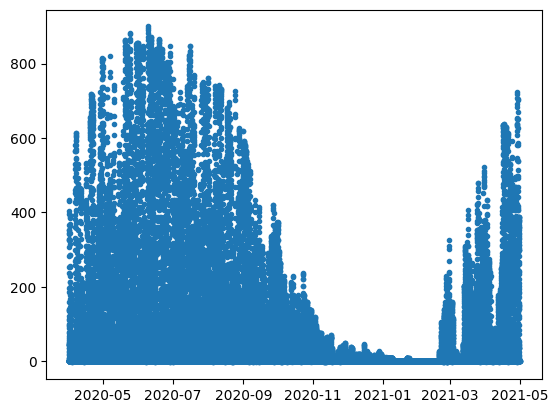

In [22]:
Y_col="pv_measurement"

df_B=df_train_and_targets

filter_all=(df_B["date_forecast"] > "2020-4-1") & (df_B["date_forecast"] < "2021-5-1")
filter_1=(df_B["date_forecast"] > "2021-3-1")& (df_B["date_forecast"] < "2021-4-20")

df_B=df_B[filter_all]
plt.plot(df_B["date_forecast"], df_B[Y_col], ".")

## 03 Min and max values

In [23]:
print(f'Location is {location}')
df_train_and_targets.describe()

Location is B


time  pv_measurement               date_forecast  \
count                      151277   151277.000000                      151277   
mean   2021-02-27 08:10:29.988696       94.683546  2021-02-27 08:10:29.988696   
min           2019-01-01 00:00:00     -265.860889         2019-01-01 00:00:00   
25%           2020-01-29 22:30:00        0.000000         2020-01-29 22:30:00   
50%           2021-02-26 21:15:00        0.000000         2021-02-26 21:15:00   
75%           2022-03-27 20:00:00      105.874453         2022-03-27 20:00:00   
max           2023-04-30 23:45:00     1041.538536         2023-04-30 23:45:00   
std                           NaN      179.506770                         NaN   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
count             151277.000000        151277.000000         127949.000000   
mean                   6.133190             1.254619           2601.811523   
min                    0.700000             1.151000             27.799999   
25%                    4.100000             1.230000           1037.199951   
50%                    5.500000             1.254000           1750.400024   
75%                    8.000000             1.278000           3360.899902   
max                   17.500000             1.426000          12328.799805   
std                    2.772179             0.035779           2320.011963   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
count           1.512770e+05    151277.000000     140974.000000   
mean            5.484771e+05       152.355515       1715.573608   
min             0.000000e+00         0.000000         27.799999   
25%             0.000000e+00         0.000000        658.000000   
50%             1.439710e+04         0.000000       1231.300049   
75%             8.883239e+05       247.199997       2093.500000   
max             3.005700e+06       836.400024      11688.900391   
std             8.453528e+05       235.423615       1662.562378   

       dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
count    151277.000000   151277.000000  151277.000000      1.512770e+05   
mean          0.009030      275.500214      41.622662      1.498415e+05   
min          -1.000000      250.899994       0.000000      0.000000e+00   
25%           0.000000      270.899994       0.000000      0.000000e+00   
50%           0.000000      275.299988       0.000000      1.540890e+04   
75%           0.000000      280.899994      70.199997      2.532398e+05   
max           1.000000      293.799988     345.700012      1.205341e+06   
std           0.122327        6.895338      62.281059      2.213709e+05   

        direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  elevation:m  \
count  151277.000000     1.512770e+05            151277.000000     151277.0   
mean       53.366875     1.921187e+05                66.711746          7.0   
min         0.000000     0.000000e+00                 0.000000          7.0   
25%         0.000000     0.000000e+00                41.200001          7.0   
50%         0.000000     0.000000e+00                79.199997          7.0   
75%        34.299999     1.320936e+05                98.699997          7.0   
max       688.700012     2.451235e+06               100.000000          7.0   
std       116.563385     4.137862e+05                34.336613          0.0   

       fresh_snow_12h:cm  fresh_snow_1h:cm  fresh_snow_24h:cm  \
count      151277.000000     151277.000000      151277.000000   
mean            0.089076          0.007382           0.177198   
min             0.000000          0.000000           0.000000   
25%             0.000000          0.000000           0.000000   
50%             0.000000          0.000000           0.000000   
75%             0.000000          0.000000           0.000000   
max            13.300000          3.600000          15.200000   
std             0.581407          0.082656           0.966550   

       fresh_snow_

##### Days with most PV

In [24]:
top_25_rows = df_train_and_targets.sort_values(by='pv_measurement', ascending=False).head(25)
top_25_rows.head(25)
top_25_rows.describe()


time  pv_measurement        date_forecast  \
count                   25       25.000000                   25   
mean   2021-01-02 14:18:36     1013.430603  2021-01-02 14:18:36   
min    2019-05-12 12:00:00      995.699954  2019-05-12 12:00:00   
25%    2019-06-18 10:30:00     1001.190155  2019-06-18 10:30:00   
50%    2022-05-12 12:00:00     1008.348750  2022-05-12 12:00:00   
75%    2022-06-18 10:30:00     1025.569222  2022-06-18 10:30:00   
max    2022-06-24 10:45:00     1041.538536  2022-06-24 10:45:00   
std                    NaN       15.580053                  NaN   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
count                 25.000000            25.000000             25.000000   
mean                   8.056000             1.220400           3076.551758   
min                    4.900000             1.200000           2407.300049   
25%                    7.100000             1.203000           2609.199951   
50%                    8.500000             1.203000           2663.199951   
75%                    9.100000             1.245000           3835.899902   
max                    9.400000             1.276000           3938.399902   
std                    1.304505             0.025736            607.996460   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
count           2.500000e+01        25.000000         25.000000   
mean            2.830684e+06       806.984009       3076.551758   
min             2.657550e+06       752.599976       2407.300049   
25%             2.757585e+06       794.599976       2609.199951   
50%             2.846508e+06       814.400024       2663.199951   
75%             2.892573e+06       824.099976       3835.899902   
max             2.961500e+06       834.400024       3938.399902   
std             9.414159e+04        24.554108        607.996460   

       dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
count             25.0       25.000000      25.000000         25.000000   
mean               0.0      280.947998     172.779999     616798.750000   
min                0.0      273.799988     120.099998     421636.500000   
25%                0.0      279.100006     146.300003     476068.593750   
50%                0.0      282.100006     159.899994     628839.687500   
75%                0.0      282.899994     212.300003     731670.687500   
max                0.0      283.399994     236.600006     818063.187500   
std                0.0        2.737415      42.072369     143017.234375   

       direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  elevation:m  \
count     25.000000     2.500000e+01                25.000000         25.0   
mean     428.679962     1.510910e+06                55.700001          7.0   
min      250.899994     9.530630e+05                24.500000          7.0   
25%      325.899994     1.058088e+06                40.000000          7.0   
50%      427.200012     1.502752e+06                51.299999          7.0   
75%      518.099976     1.974460e+06                88.300003          7.0   
max      594.599976     2.072821e+06                91.099998          7.0   
std      114.769775     4.185923e+05                23.815174          0.0   

       fresh_snow_12h:cm  fresh_snow_1h:cm  fresh_snow_24h:cm  \
count               25.0              25.0               25.0   
mean                 0.0               0.0                0.0   
min                  0.0               0.0                0.0   
25%                  0.0               0.0                0.0   
50%                  0.0               0.0                0.0   
75%                  0.0               0.0                0.0   
max                  0.0               0.0                0.0   
std                  0.0               0.0                0.0   

       fresh_snow_3h:cm  fresh_snow_6h:cm  is_day:idx  is_in_shadow:idx  \
count              25.0              25.0        25.0              25.0

In [25]:
df_train_and_targets.head(60-100)

time  pv_measurement       date_forecast  \
0      2019-01-01 00:00:00        0.000000 2019-01-01 00:00:00   
1      2019-01-01 00:15:00        0.000000 2019-01-01 00:15:00   
2      2019-01-01 00:30:00        0.000000 2019-01-01 00:30:00   
3      2019-01-01 00:45:00        0.000000 2019-01-01 00:45:00   
4      2019-01-01 01:00:00        0.000000 2019-01-01 01:00:00   
...                    ...             ...                 ...   
151232 2023-04-30 12:45:00      354.246062 2023-04-30 12:45:00   
151233 2023-04-30 13:00:00      428.652000 2023-04-30 13:00:00   
151234 2023-04-30 13:15:00      458.925372 2023-04-30 13:15:00   
151235 2023-04-30 13:30:00      474.257048 2023-04-30 13:30:00   
151236 2023-04-30 13:45:00      470.314201 2023-04-30 13:45:00   

        absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
0                            5.6                1.239           1226.400024   
1                            5.6                1.239           1209.300049   
2                            5.5                1.240           1192.099976   
3                            5.4                1.241           1174.900024   
4                            5.4                1.241           1157.599976   
...                          ...                  ...                   ...   
151232                       5.2                1.265           3078.899902   
151233                       5.1                1.264           3282.600098   
151234                       5.0                1.265           3728.899902   
151235                       4.9                1.265           4175.299805   
151236                       4.9                1.265           4621.600098   

        clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
0                        0.00         0.000000       1226.400024   
1                        0.00         0.000000       1209.300049   
2                        0.00         0.000000       1192.099976   
3                        0.00         0.000000       1174.900024   
4                        0.00         0.000000       1157.599976   
...                       ...              ...               ...   
151232             2487706.50       668.900024        501.799988   
151233             2449324.25       653.700012        553.400024   
151234             2402724.75       636.299988        602.599976   
151235             2348135.00       616.900024        651.799988   
151236             2285822.75       595.500000        701.000000   

        dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
0                   0.0      275.399994       0.000000            0.0000   
1                   0.0      275.200012       0.000000            0.0000   
2                   0.0      275.100006       0.000000            0.0000   
3                   0.0      274.899994       0.000000            0.0000   
4                   0.0      274.700012       0.000000            0.0000   
...                 ...             ...            ...               ...   
151232              0.0      274.299988     265.399994       884121.1875   
151233              0.0      274.000000     263.600006       907280.8750   
151234              0.0      273.799988     260.700012       926418.6250   
151235              0.0      273.600006     256.700012       941247.1875   
151236              0.0      273.399994     234.399994       899777.8125   

        direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  elevation:m  \
0           0.000000          0.00000                69.599998          7.0   
1           0.000000          0.00000                78.599998          7.0   
2           0.000000          0.00000                86.300003          7.0   
3           0.000000          0.00000                92.800003          7.0   
4           0.000000          0.00000                98.099998          7.0   
...              ...              ...                      ...          ... 

## 04 Correlations and relationships

#### Correlation matrix - Correlation with PV measurement

In [26]:
corr_matrix = df_train_and_targets.corr()
corr_matrix["pv_measurement"].sort_values(ascending = False)

pv_measurement                    1.000000
direct_rad:W                      0.825447
clear_sky_rad:W                   0.824438
direct_rad_1h:J                   0.809289
clear_sky_energy_1h:J             0.808815
diffuse_rad:W                     0.704718
diffuse_rad_1h:J                  0.697346
sun_elevation:d                   0.665565
is_day:idx                        0.488172
t_1000hPa:K                       0.392200
absolute_humidity_2m:gm3          0.296259
dew_point_2m:K                    0.295862
cloud_base_agl:m                  0.218284
pressure_100m:hPa                 0.164605
pressure_50m:hPa                  0.159192
visibility:m                      0.157376
msl_pressure:hPa                  0.155517
sfc_pressure:hPa                  0.153789
ceiling_height_agl:m              0.147826
snow_drift:idx                   -0.003836
wind_speed_w_1000hPa:ms          -0.007268
prob_rime:p                      -0.012236
snow_melt_10min:mm               -0.014712
time       

#### Correlation plots

##### Plot of positive correlations

array([[<Axes: xlabel='pv_measurement', ylabel='pv_measurement'>,
        <Axes: xlabel='direct_rad:W', ylabel='pv_measurement'>,
        <Axes: xlabel='direct_rad_1h:J', ylabel='pv_measurement'>,
        <Axes: xlabel='clear_sky_rad:W', ylabel='pv_measurement'>,
        <Axes: xlabel='clear_sky_energy_1h:J', ylabel='pv_measurement'>,
        <Axes: xlabel='diffuse_rad:W', ylabel='pv_measurement'>,
        <Axes: xlabel='diffuse_rad_1h:J', ylabel='pv_measurement'>,
        <Axes: xlabel='sun_elevation:d', ylabel='pv_measurement'>,
        <Axes: xlabel='is_day:idx', ylabel='pv_measurement'>],
       [<Axes: xlabel='pv_measurement', ylabel='direct_rad:W'>,
        <Axes: xlabel='direct_rad:W', ylabel='direct_rad:W'>,
        <Axes: xlabel='direct_rad_1h:J', ylabel='direct_rad:W'>,
        <Axes: xlabel='clear_sky_rad:W', ylabel='direct_rad:W'>,
        <Axes: xlabel='clear_sky_energy_1h:J', ylabel='direct_rad:W'>,
        <Axes: xlabel='diffuse_rad:W', ylabel='direct_rad:W'>,
        <A

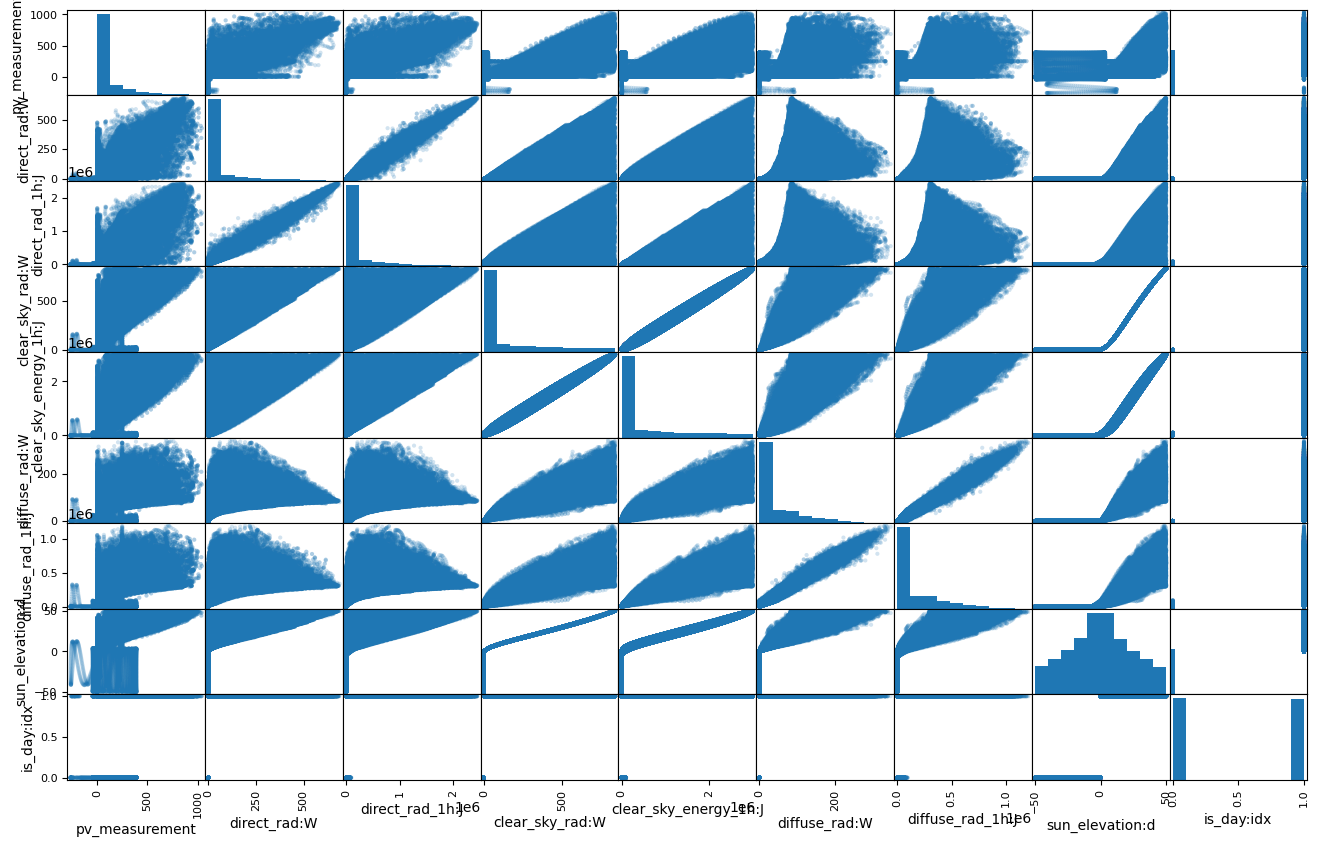

In [27]:
attributes = ["pv_measurement",
"direct_rad:W",
"direct_rad_1h:J",
"clear_sky_rad:W",
"clear_sky_energy_1h:J",
"diffuse_rad:W",
"diffuse_rad_1h:J",
"sun_elevation:d",
"is_day:idx",
]

scatter_matrix(df_train_and_targets[attributes], figsize= (16, 10), alpha=0.2)

##### Plot of negative correlations

array([[<Axes: xlabel='pv_measurement', ylabel='pv_measurement'>,
        <Axes: xlabel='effective_cloud_cover:p', ylabel='pv_measurement'>,
        <Axes: xlabel='relative_humidity_1000hPa:p', ylabel='pv_measurement'>,
        <Axes: xlabel='is_in_shadow:idx', ylabel='pv_measurement'>],
       [<Axes: xlabel='pv_measurement', ylabel='effective_cloud_cover:p'>,
        <Axes: xlabel='effective_cloud_cover:p', ylabel='effective_cloud_cover:p'>,
        <Axes: xlabel='relative_humidity_1000hPa:p', ylabel='effective_cloud_cover:p'>,
        <Axes: xlabel='is_in_shadow:idx', ylabel='effective_cloud_cover:p'>],
       [<Axes: xlabel='pv_measurement', ylabel='relative_humidity_1000hPa:p'>,
        <Axes: xlabel='effective_cloud_cover:p', ylabel='relative_humidity_1000hPa:p'>,
        <Axes: xlabel='relative_humidity_1000hPa:p', ylabel='relative_humidity_1000hPa:p'>,
        <Axes: xlabel='is_in_shadow:idx', ylabel='relative_humidity_1000hPa:p'>],
       [<Axes: xlabel='pv_measurement', ylabe

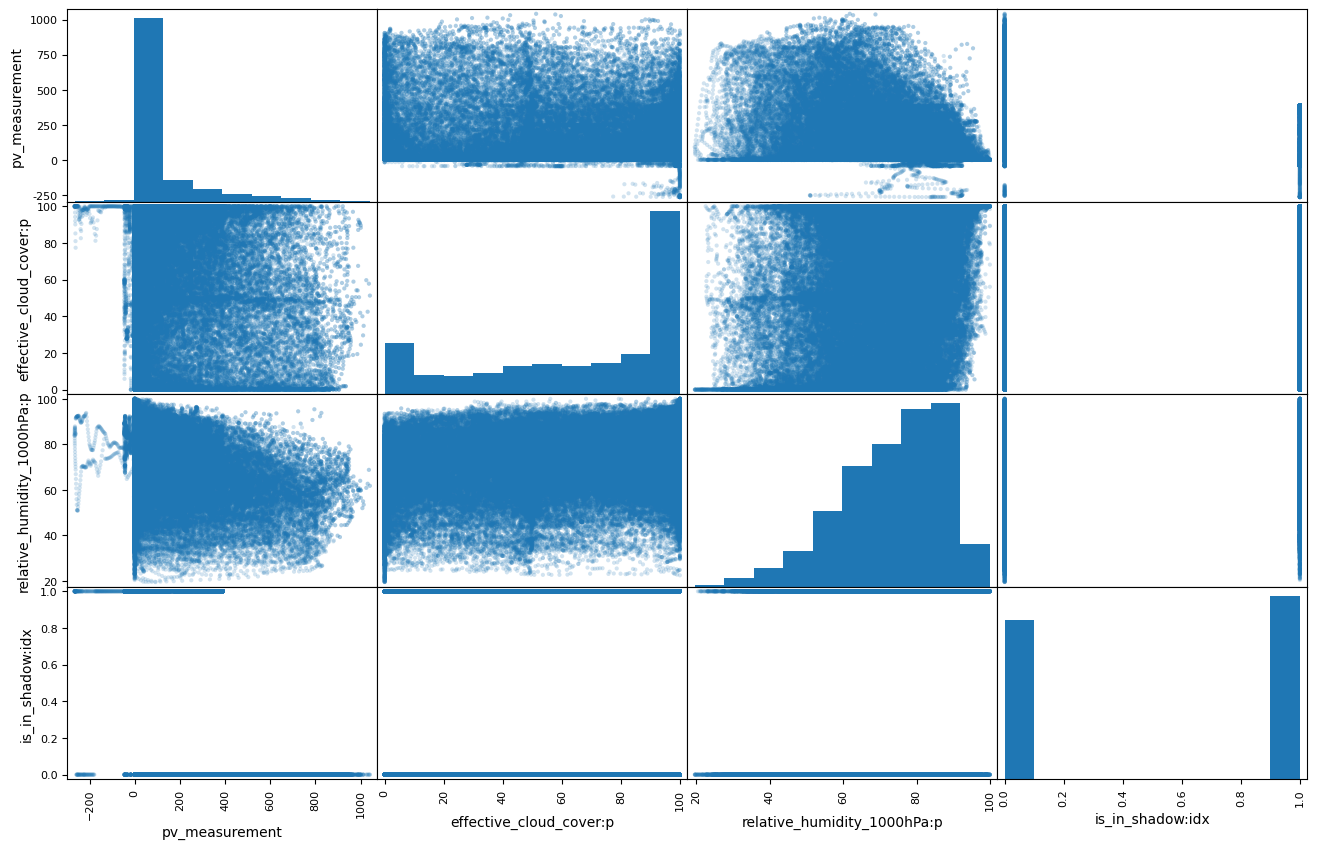

In [28]:
attributes = ["pv_measurement",
              "effective_cloud_cover:p",
    "relative_humidity_1000hPa:p",
    "is_in_shadow:idx"
]

scatter_matrix(df_train_and_targets[attributes], figsize= (16, 10), alpha=0.2)

#### Seaborn correlation plot

In [29]:
#sns.pairplot(df_train_and_targets)

#### 05 Observed vs. estimated weather

In [30]:
X_train_observed.describe()

date_forecast  absolute_humidity_2m:gm3  \
count                      133710             133710.000000   
mean   2020-11-27 06:42:25.402737                  6.401263   
min           2019-01-01 00:00:00                  0.700000   
25%           2019-12-15 04:48:45                  4.300000   
50%           2020-11-27 09:37:30                  5.900000   
75%           2021-11-10 14:26:15                  8.300000   
max           2022-10-23 20:00:00                 17.500000   
std                           NaN                  2.788315   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
count        133710.000000         114071.000000           1.337100e+05   
mean              1.251222           2523.139404           5.893502e+05   
min               1.151000             27.799999           0.000000e+00   
25%               1.227000           1026.400024           0.000000e+00   
50%               1.250000           1693.199951           3.169310e+04   
75%               1.274000           3136.199951           1.008053e+06   
max               1.426000          12328.799805           3.005700e+06   
std               0.035173           2285.160889           8.711696e+05   

       clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
count    133710.000000     125370.000000    133710.000000   133710.000000   
mean        163.708374       1731.708618         0.009281      276.195435   
min           0.000000         27.900000        -1.000000      250.899994   
25%           0.000000        687.099976         0.000000      271.600006   
50%           7.000000       1264.400024         0.000000      276.100006   
75%         280.500000       2109.500000         0.000000      281.500000   
max         836.400024      11688.900391         1.000000      293.799988   
std         242.617630       1652.848755         0.117801        6.784175   

       diffuse_rad:W  diffuse_rad_1h:J   direct_rad:W  direct_rad_1h:J  \
count  133710.000000      1.337100e+05  133710.000000     1.337100e+05   
mean       44.089165      1.587211e+05      56.991596     2.051701e+05   
min         0.000000      0.000000e+00       0.000000     0.000000e+00   
25%         0.000000      0.000000e+00       0.000000     0.000000e+00   
50%         3.300000      2.347370e+04       0.000000     1.082500e+02   
75%        75.099998      2.703476e+05      42.299999     1.605265e+05   
max       345.700012      1.205341e+06     688.700012     2.451235e+06   
std        63.722904      2.264691e+05     120.148399     4.264330e+05   

       effective_cloud_cover:p  elevation:m  fresh_snow_12h:cm  \
count            133710.000000     133710.0      133710.000000   
mean                 66.499352          7.0           0.063074   
min                   0.000000          7.0           0.000000   
25%                  41.099998          7.0           0.000000   
50%                  78.599998          7.0           0.000000   
75%                  98.400002          7.0           0.000000   
max                 100.000000          7.0          13.300000   
std                  34.178120          0.0           0.509971   

       fresh_snow_1h:cm  fresh_snow_24h:cm  fresh_snow_3h:cm  \
count     133710.000000      133710.000000     133710.000000   
mean           0.005251           0.126225          0.015771   
min            0.000000           0.000000          0.000000   
25%            0.000000           0.000000          0.000000   
50%            0.000000           0.000000          0.000000   
75%            0.000000           0.000000          0.000000   
max            3.600000          15.200000          7.900000   
std            0.070779           0.857328          0.174102   

       fresh_snow_6h:cm     is_day:idx  is_in_shadow:idx  msl_pressure:hPa  \
count     133710.000000  133710.000000     133710.000000     133710.000000   
mean           0.031537       0.517358          0.515167       1009.567566   
min      

In [31]:
X_train_estimated.describe()

date_calc               date_forecast  \
count                       17576                       17576   
mean   2023-01-27 19:07:13.160673  2023-01-28 23:11:50.127446   
min           2022-10-27 07:00:18         2022-10-28 22:00:00   
25%           2022-12-12 08:00:05         2022-12-13 16:26:15   
50%           2023-01-28 08:00:04         2023-01-29 10:52:30   
75%           2023-03-15 08:00:04         2023-03-16 05:18:45   
max           2023-04-29 07:00:05         2023-04-30 23:45:00   
std                           NaN                         NaN   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
count              17576.000000         17576.000000          13887.000000   
mean                   4.093150             1.280473           3247.021729   
min                    1.000000             1.210000             27.900000   
25%                    3.000000             1.261000           1180.500000   
50%                    3.900000             1.278000           2736.800049   
75%                    5.100000             1.299000           4755.000000   
max                    8.800000             1.370000          12316.700195   
std                    1.513466             0.029161           2496.413330   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
count           1.757600e+04     17576.000000      15613.000000   
mean            2.371212e+05        65.866737       1585.469604   
min             0.000000e+00         0.000000         27.799999   
25%             0.000000e+00         0.000000        499.500000   
50%             0.000000e+00         0.000000        940.099976   
75%             1.374692e+05        37.400002       1927.599976   
max             2.555956e+06       711.599976      10814.500000   
std             5.173369e+05       144.161041       1732.807373   

       dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
count     17576.000000    17576.000000   17576.000000      1.757600e+04   
mean          0.007112      270.210114      22.829742      8.218720e+04   
min          -1.000000      254.699997       0.000000      0.000000e+00   
25%           0.000000      266.799988       0.000000      0.000000e+00   
50%           0.000000      270.399994       0.000000      0.000000e+00   
75%           0.000000      273.899994      22.900000      8.015687e+04   
max           1.000000      282.100006     300.399994      1.060716e+06   
std           0.152385        5.237202      45.787643      1.626306e+05   

       direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  elevation:m  \
count  17576.000000     1.757600e+04             17576.000000      17576.0   
mean      25.729755     9.262709e+04                68.355965          7.0   
min        0.000000     0.000000e+00                 0.000000          7.0   
25%        0.000000     0.000000e+00                42.799999          7.0   
50%        0.000000     0.000000e+00                84.300003          7.0   
75%        0.800000     1.074095e+04                99.800003          7.0   
max      530.400024     1.893064e+06               100.000000          7.0   
std       79.091415     2.811896e+05                35.471504          0.0   

       fresh_snow_12h:cm  fresh_snow_1h:cm  fresh_snow_24h:cm  \
count       17576.000000      17576.000000       17576.000000   
mean            0.286846          0.023595           0.564890   
min             0.000000          0.000000           0.000000   
25%             0.000000          0.000000           0.000000   
50%             0.000000          0.000000           0.000000   
75%             0.000000          0.000000           0.000000   
max             9.500000          3.500000          12.500000   
std             0.941684          0.142812           1.509728   

       fresh_snow_3h:cm  fresh_snow_6h:cm    is_day:idx  is_in_shadow:idx  \
count      17576.000000      17576.000000  17576.000000      17576.000000   
mean        

##### Median value Comparison between observed and estimated (normalized)

C:\Users\sver-\AppData\Local\Temp\ipykernel_2076\2889450044.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(col, (df1_medians[i], df2_medians[i]), fontsize=9)


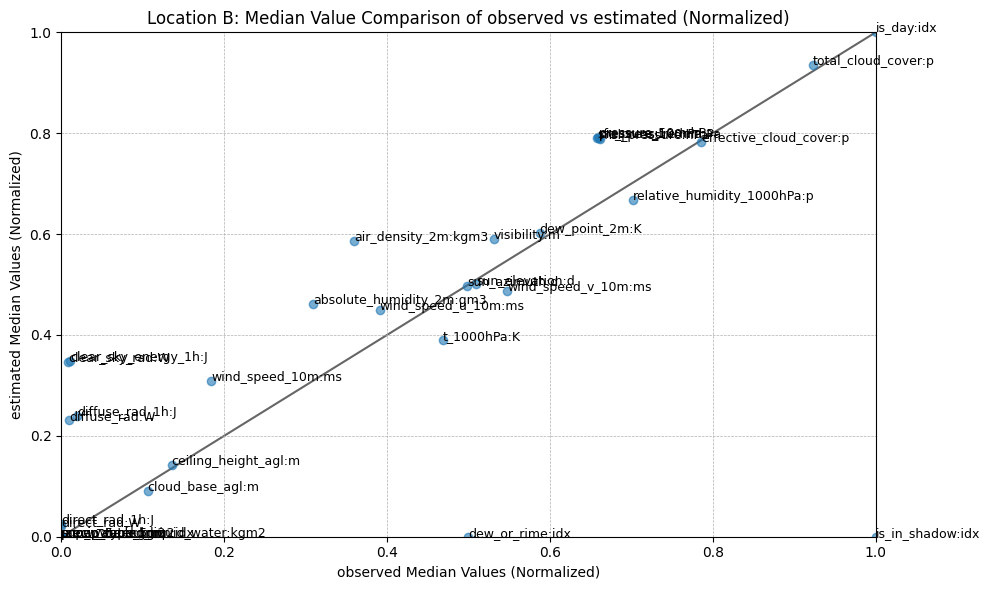

In [32]:
observed = X_train_observed.copy()
estimated = X_test_estimated.copy()

observed = observed.drop(columns=["date_forecast"])
estimated = estimated.drop(columns=["date_calc", "date_forecast"])


# Normalize columns to [0, 1]
df1_normalized = (observed - observed.min()) / (observed.max() - observed.min())
df2_normalized = (estimated - estimated.min()) / (estimated.max() - estimated.min())
df1_medians = df1_normalized.median()
df2_medians = df2_normalized.median()

plt.figure(figsize=(10, 6))
plt.scatter(df1_medians, df2_medians, alpha=0.6)

lims = [0, 1]
plt.plot(lims, lims, 'k-', alpha=0.6, zorder=0)
plt.xlim(lims)
plt.ylim(lims)

for i, col in enumerate(df1_normalized.columns):
    plt.annotate(col, (df1_medians[i], df2_medians[i]), fontsize=9)

plt.title(f"Location {location}: Median Value Comparison of observed vs estimated (Normalized)")
plt.xlabel("observed Median Values (Normalized)")
plt.ylabel("estimated Median Values (Normalized)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()




#### PV-correlation between observed and estimated seperately

In [33]:
df_X_train_observed_and_targets = pd.merge(left = train_targets, right = X_train_observed, left_on="time", right_on="date_forecast")
df_X_train_estimated_and_targets = pd.merge(left = train_targets, right = X_train_estimated, left_on="time", right_on="date_forecast")
print(f'Shape of x_train observed and targets{df_X_train_observed_and_targets.shape}')
print(f'Shape of x_train estimated and targets{df_X_train_estimated_and_targets.shape}')

Shape of x_train observed and targets(133701, 48)
Shape of x_train estimated and targets(17576, 49)


#### Correlation values for observed and estimated

In [34]:
corr_matrix_observed = df_X_train_observed_and_targets.corr()
corr_matrix_observed["pv_measurement"].sort_values(ascending = False)

pv_measurement                    1.000000
clear_sky_rad:W                   0.847557
direct_rad:W                      0.846773
clear_sky_energy_1h:J             0.830595
direct_rad_1h:J                   0.829313
diffuse_rad:W                     0.730715
diffuse_rad_1h:J                  0.722376
sun_elevation:d                   0.703669
is_day:idx                        0.513332
t_1000hPa:K                       0.410191
dew_point_2m:K                    0.313188
absolute_humidity_2m:gm3          0.307129
cloud_base_agl:m                  0.229996
pressure_100m:hPa                 0.185395
pressure_50m:hPa                  0.179672
msl_pressure:hPa                  0.175836
sfc_pressure:hPa                  0.173966
visibility:m                      0.163312
ceiling_height_agl:m              0.159418
date_forecast                     0.013104
time                              0.013104
snow_drift:idx                   -0.004137
wind_speed_w_1000hPa:ms          -0.007926
prob_rime:p

In [35]:
corr_matrix_estimated = df_X_train_estimated_and_targets.corr()
corr_matrix_estimated["pv_measurement"].sort_values(ascending = False)

pv_measurement                    1.000000
direct_rad_1h:J                   0.444947
direct_rad:W                      0.439630
clear_sky_energy_1h:J             0.396862
clear_sky_rad:W                   0.390287
diffuse_rad_1h:J                  0.274207
diffuse_rad:W                     0.267303
sun_elevation:d                   0.201004
is_day:idx                        0.173005
snow_depth:cm                     0.171234
ceiling_height_agl:m              0.135162
visibility:m                      0.121062
snow_melt_10min:mm                0.095597
cloud_base_agl:m                  0.089321
time                              0.087100
date_forecast                     0.087100
date_calc                         0.087059
prob_rime:p                       0.043470
t_1000hPa:K                       0.041753
wind_speed_v_10m:ms               0.031392
sun_azimuth:d                     0.021490
wind_speed_10m:ms                -0.004274
pressure_100m:hPa                -0.023539
pressure_50

In [36]:
diff = corr_matrix_observed - corr_matrix_estimated
diff["pv_measurement"].sort_values(ascending = False)

sun_elevation:d                   0.502664
diffuse_rad:W                     0.463412
clear_sky_rad:W                   0.457270
diffuse_rad_1h:J                  0.448169
clear_sky_energy_1h:J             0.433733
direct_rad:W                      0.407143
direct_rad_1h:J                   0.384366
absolute_humidity_2m:gm3          0.383229
dew_point_2m:K                    0.375327
t_1000hPa:K                       0.368438
is_day:idx                        0.340327
pressure_100m:hPa                 0.208934
pressure_50m:hPa                  0.203600
msl_pressure:hPa                  0.200094
sfc_pressure:hPa                  0.198346
cloud_base_agl:m                  0.140675
fresh_snow_12h:cm                 0.056020
dew_or_rime:idx                   0.046702
fresh_snow_24h:cm                 0.044706
fresh_snow_6h:cm                  0.043787
visibility:m                      0.042251
fresh_snow_3h:cm                  0.026456
ceiling_height_agl:m              0.024256
precip_5min

## 06 Findings and recommendations cutoff is ~~ +/- 0.3

## Feature ideas (add stuff below)

##### PV by season and time of day

        pv_measurement                time  hour  season
0                  0.0 2019-01-01 00:00:00     0  winter
1                  0.0 2019-01-01 00:15:00     0  winter
2                  0.0 2019-01-01 00:30:00     0  winter
3                  0.0 2019-01-01 00:45:00     0  winter
4                  0.0 2019-01-01 01:00:00     1  winter
...                ...                 ...   ...     ...
151272             0.0 2023-04-30 22:45:00    22  spring
151273            -0.0 2023-04-30 23:00:00    23  spring
151274             0.0 2023-04-30 23:15:00    23  spring
151275             0.0 2023-04-30 23:30:00    23  spring
151276             0.0 2023-04-30 23:45:00    23  spring

[151277 rows x 4 columns]


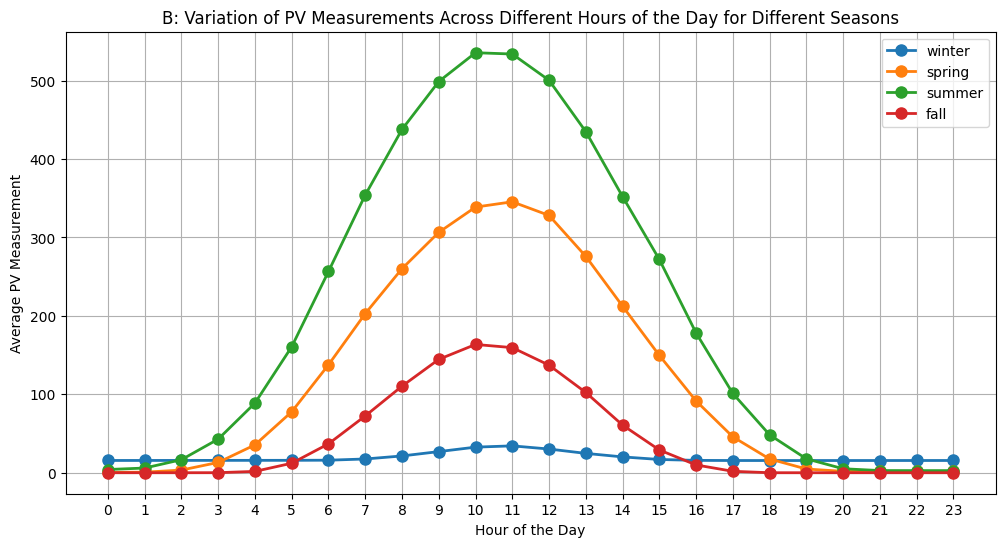

In [37]:
selected_columns = ['pv_measurement', 'time']
date_pv = df_train_and_targets[selected_columns].copy()
# Extracting hours from the ‘time’ column
date_pv['hour'] = date_pv['time'].dt.hour
# Create ‘season’ column based on month
date_pv['season'] = date_pv['time'].dt.month % 12 // 3 + 1
date_pv['season'] = date_pv['season'].map({1:'winter', 2:'spring', 3:'summer', 4:'fall'})
print(date_pv)
# Filter data for each season and calculate hourly mean PV measurement
seasons = ['winter', 'spring', 'summer', 'fall']
plt.figure(figsize=(12, 6))
for season in seasons:
    # Filter data for the current season
    season_data = date_pv[date_pv['season'] == season]
    # Group by hour and calculate mean PV measurement for the current season
    hourly_pv_means = season_data.groupby('hour')['pv_measurement'].mean()
    # Plotting for the current season
    plt.plot(hourly_pv_means.index, hourly_pv_means.values, marker='o', label=season, linewidth=2, markersize=8)
plt.xlabel('Hour of the Day')
plt.ylabel('Average PV Measurement')
plt.title(f'{location}: Variation of PV Measurements Across Different Hours of the Day for Different Seasons')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

#### Aryan pv and time feature

In [38]:
selected_columns = ['pv_measurement', 'time']
date_pv = df_train_and_targets[selected_columns].copy()
# Extracting hours from the ‘time’ column
date_pv['hour'] = date_pv['time'].dt.hour
# Calculate the absolute distance from 11 o’clock for each timestamp
date_pv['distance_from_11'] = abs(date_pv['hour'] - 11)
# If the hour is 11, set the distance feature to 1, else keep the calculated absolute distance
date_pv['distance_from_11'] = date_pv.apply(lambda row: 0 if row['hour'] == 11 else row['distance_from_11'], axis=1)
# Normalize the distance_from_11 feature considering the maximum distance as 12
max_distance = 12
date_pv['normalized_distance_from_11'] = 1 - (date_pv['distance_from_11'] / max_distance)
date_pv.drop(columns=['distance_from_11'], inplace=True)